<hr style="margin-bottom: 10px;">
<div style="display:flex;align-items:center;justify-content: space-between;width:100%;">

<img src="https://cdn.pnggallery.com/wp-content/uploads/blinkit-logo-01.png"
    style="width:70px;height:auto;vertical-align:middle;margin-right:15px;float:left">
<h1 style="margin-left:50px;align=left"> Blinkit Data Analysis</h1>
</div>
<hr style="margin-bottom: 10px;">









In [1]:
# Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import kaggle


In [2]:
# download dataset using kaggle api
!kaggle datasets download -d akxiit/blinkit-sales-dataset

Dataset URL: https://www.kaggle.com/datasets/akxiit/blinkit-sales-dataset
License(s): MIT
blinkit-sales-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# extract files from zip file
import zipfile
zip_ref=(zipfile.ZipFile('blinkit-sales-dataset.zip'))
zip_ref.extractall() # extract file to directory
zip_ref.close() # close file


In [4]:
# reading csv files into DataFrames
o_df = pd.read_csv("blinkit_orders.csv")
oi_df = pd.read_csv("blinkit_order_items.csv")
c_df = pd.read_csv("blinkit_customers.csv")
cf_df = pd.read_csv("blinkit_customer_feedback.csv")
inv_df = pd.read_csv("blinkit_inventory.csv")
delp_df = pd.read_csv("blinkit_delivery_performance.csv")
pr_df = pd.read_csv("blinkit_products.csv")

# Data Cleaning & Wrangling

In [5]:
df_list = [o_df,oi_df,c_df,cf_df,inv_df,delp_df,pr_df]

for d in df_list:
    print('-'*50)
    print(f"There are {d.shape} Rows and Colums \n")
    if not any(d.duplicated()):
        print ("No duplicate rows ")
    else:
        print("There are duplicate rows that needs to be treated!")
    print("")
    print (d.info())
    print('-'*50)


--------------------------------------------------
There are (5000, 10) Rows and Colums 

No duplicate rows 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                5000 non-null   int64  
 1   customer_id             5000 non-null   int64  
 2   order_date              5000 non-null   object 
 3   promised_delivery_time  5000 non-null   object 
 4   actual_delivery_time    5000 non-null   object 
 5   delivery_status         5000 non-null   object 
 6   order_total             5000 non-null   float64
 7   payment_method          5000 non-null   object 
 8   delivery_partner_id     5000 non-null   int64  
 9   store_id                5000 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 390.8+ KB
None
--------------------------------------------------
---------------------------

> We see that there are no null values and no duplicate rows. 
Now let's change the data types :

In [6]:
o_df['order_date']=pd.to_datetime(o_df['order_date'])
o_df['promised_delivery_time']=pd.to_datetime(o_df['promised_delivery_time'])
o_df['actual_delivery_time']=pd.to_datetime(o_df['actual_delivery_time'])

In [7]:
c_df['registration_date']=pd.to_datetime(c_df['registration_date'])

> Let's add some neccesary columns for the analysis :

In [8]:
o_df['Year']=o_df['order_date'].dt.year
o_df['Month']=o_df['order_date'].dt.month
o_df['MonthName'] = o_df['order_date'].dt.strftime('%B')  # For month name as a string
o_df['delivery_time_wrt_order_time'] =  (o_df['actual_delivery_time'] - o_df['order_date']).dt.total_seconds() / 60

In [9]:
oi_df['product_costprice'] = oi_df['quantity']*oi_df['unit_price']

In [10]:
hostname = "localhost"
username = "root"
password = "Mysql26%40"
port = 3306
database = "blinkit_db"
engine = create_engine('mysql+pymysql://'+username+':'+password+'@'+hostname+':'+str(port)+'/'+database)
conn = engine.connect()

In [11]:
def load_dataframe(df,table_name,engine):
    df.to_sql(table_name,con=engine,if_exists='replace',index=False)
    
# load each dataframe into seperate tables
load_dataframe(o_df,"orders",engine)
load_dataframe(oi_df,"order_items",engine)
load_dataframe(c_df,"customers",engine)
load_dataframe(cf_df,"customer_feedback",engine)
load_dataframe(inv_df,"inventory",engine)
load_dataframe(delp_df,"delivery_performance",engine)
load_dataframe(pr_df,"products",engine)

In [12]:
tables = pd.read_sql_query("select Table_name as TableName from information_schema.tables where table_schema ='blinkit_db'",conn)
tables

,TableName
0,customer_feedback
1,customers
2,delivery_performance
3,inventory
4,order_items
5,orders
6,products


In [13]:
# explore what type of data is available in the tables
for table in  tables['TableName']:
    display(pd.read_sql_query(f"select * from {table} limit 5",conn))

,feedback_id,order_id,customer_id,rating,feedback_text,feedback_category,sentiment,feedback_date
0,2234710,1961864118,30065862,4,"It was okay, nothing special.",Delivery,Neutral,2024-07-17
1,5450964,1549769649,9573071,3,The order was incorrect.,App Experience,Negative,2024-05-28
2,482108,9185164487,45477575,3,"It was okay, nothing special.",App Experience,Neutral,2024-09-23
3,4823104,9644738826,88067569,4,The product met my expectations.,App Experience,Neutral,2023-11-24
4,3537464,5427684290,83298567,3,Product was damaged during delivery.,Delivery,Negative,2023-11-20


,customer_id,customer_name,email,phone,address,area,pincode,registration_date,customer_segment,total_orders,avg_order_value
0,97475543,Niharika Nagi,ektataneja@example.org,912987579691,"23, Nayar Path, Bihar Sharif-154625",Udupi,321865,2023-05-13,Premium,13,451.92
1,22077605,Megha Sachar,vedant45@example.com,915123179717,"51/302, Buch Chowk\nSrinagar-570271",Aligarh,149394,2024-06-18,Inactive,4,825.48
2,47822591,Hema Bahri,samiazaan@example.com,910034076149,"941\nAnne Street, Darbhanga 186125",Begusarai,621411,2024-09-25,Regular,17,1969.81
3,79726146,Zaitra Vig,ishanvi87@example.org,916264232390,"43/94, Ghosh, Alappuzha 635655",Kozhikode,826054,2023-10-04,New,4,220.09
4,57102800,Januja Verma,atideshpande@example.org,917293526596,"06\nOm, Ambarnath 477463",Ichalkaranji,730539,2024-03-22,Inactive,14,578.14


,order_id,delivery_partner_id,promised_time,actual_time,delivery_time_minutes,distance_km,delivery_status,reasons_if_delayed
0,1961864118,63230,2024-07-17 08:52:01,2024-07-17 08:47:01,-5.0,0.96,On Time,None
1,1549769649,14983,2024-05-28 13:25:29,2024-05-28 13:27:29,2.0,0.98,On Time,Traffic
2,9185164487,39859,2024-09-23 13:25:12,2024-09-23 13:29:12,4.0,3.83,On Time,Traffic
3,9644738826,61497,2023-11-24 16:34:56,2023-11-24 16:33:56,-1.0,2.76,On Time,None
4,5427684290,84315,2023-11-20 05:17:39,2023-11-20 05:18:39,1.0,2.63,On Time,Traffic


,product_id,date,stock_received,damaged_stock
0,153019,17-03-2023,4,2
1,848226,17-03-2023,4,2
2,965755,17-03-2023,1,0
3,39154,17-03-2023,4,0
4,34186,17-03-2023,3,2


,order_id,product_id,quantity,unit_price,product_costprice
0,1961864118,642612,3,517.03,1551.09
1,1549769649,378676,1,881.42,881.42
2,9185164487,741341,2,923.84,1847.68
3,9644738826,561860,1,874.78,874.78
4,5427684290,602241,2,976.55,1953.10


,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,order_total,payment_method,delivery_partner_id,store_id,Year,Month,MonthName,delivery_time_wrt_order_time
0,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,2024,7,July,13.0
1,1549769649,9573071,2024-05-28 13:14:29,2024-05-28 13:25:29,2024-05-28 13:27:29,On Time,976.55,Cash,14983,7534,2024,5,May,13.0
2,9185164487,45477575,2024-09-23 13:07:12,2024-09-23 13:25:12,2024-09-23 13:29:12,On Time,839.05,UPI,39859,9886,2024,9,September,22.0
3,9644738826,88067569,2023-11-24 16:16:56,2023-11-24 16:34:56,2023-11-24 16:33:56,On Time,440.23,Card,61497,7917,2023,11,November,17.0
4,5427684290,83298567,2023-11-20 05:00:39,2023-11-20 05:17:39,2023-11-20 05:18:39,On Time,2526.68,Cash,84315,2741,2023,11,November,18.0


,product_id,product_name,category,brand,price,mrp,margin_percentage,shelf_life_days,min_stock_level,max_stock_level
0,153019,Onions,Fruits & Vegetables,Aurora LLC,947.95,1263.93,25.0,3,13,88
1,11422,Potatoes,Fruits & Vegetables,Ramaswamy-Tata,127.16,169.55,25.0,3,20,65
2,669378,Potatoes,Fruits & Vegetables,Chadha and Sons,212.14,282.85,25.0,3,23,70
3,848226,Tomatoes,Fruits & Vegetables,Barad and Sons,209.59,279.45,25.0,3,10,51
4,890623,Onions,Fruits & Vegetables,"Sangha, Nagar and Varty",354.52,472.69,25.0,3,27,55


# Data Analysis and Visualizations

## Sales Insights

### 1) A report that shows all key metrics of business 

In [14]:
report = pd.read_sql_query("""select "Total Sales" as measure_name , sum(order_total) as measure_value from orders
                  union all
                  select "Total Quantity", sum(quantity) from order_items
                  union all
                  select "Total Orders", count(distinct order_id) from orders
                  union all
                  select "Total Products", count(distinct product_id) from products
                  """,conn)
display(report)

,measure_name,measure_value
0,Total Sales,11009308.5
1,Total Quantity,10034.0
2,Total Orders,5000.0
3,Total Products,268.0


### 2) Sales by Year

In [15]:
df=pd.read_sql_query("""select Year,Month,MonthName ,sum(order_total) as Total,count(distinct order_id) as Total_Orders
                    from orders
                    group by Year,Month,MonthName
                    order by Month""",conn)
df1=df.groupby('Year')['Total'].sum()
df1

Year
2023    5464757.6
2024    5544550.9
Name: Total, dtype: float64

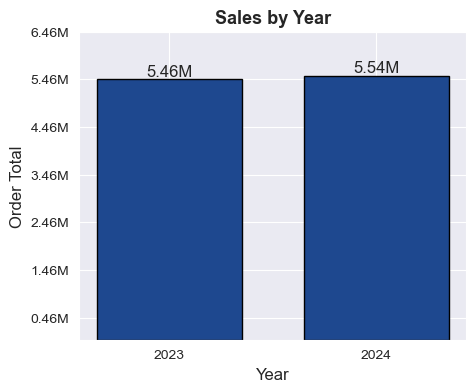

In [16]:
# Bar chart comparing total sales per year

# Setting the seaborn style to "darkgrid" for better visualization aesthetics
sns.set_style('darkgrid')

# Set up the plot
plt.figure(figsize=(5,4))

# Enhance the plot
bars=plt.bar(df1.index,df1.values,color='#1e488f',edgecolor='k',width = 0.7)
plt.title("Sales by Year",fontdict={'fontweight' : 'bold','fontsize':13})
plt.xlabel('Year',fontsize=12)
plt.ylabel("Order Total",fontsize=12)
# adding bar labels
for bar in bars:
    height=bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,height,f"{height/1e6:.2f}M",ha='center',va='bottom',fontsize=12 )
y_min,y_max=df1.values.min(),df1.values.max()
plt.yticks(np.arange(y_min-5e6,y_max+1e6,1e6),labels=[f"{y/1e6:.2f}M" for y in np.arange(y_min-5e6,y_max+1e6,1e6)])
plt.xticks(df1.index.unique())
plt.savefig('x.png',dpi=300)
# Display the plot
plt.show()

> The bar chart indicates that sales in 2024 are slightly higher than in 2023. The difference though small, highlights a positive growth trajectory, which could further be analyzed by examining monthly sales patterns.

### 3) Monthly Sales Trend

In [17]:
# Reviewing the time span from the first to the last order
pd.read_sql_query("""select min(order_date) as first_order,max(order_date) as last_order from orders""",conn)

,first_order,last_order
0,2023-03-16 08:10:44,2024-11-04 20:29:15


In [18]:
# Extracting the Monthly Sales data for the year 2023
df_23=pd.read_sql_query("""select Year,Month,MonthName ,sum(order_total) as Total,count(distinct order_id) as Total_Orders
                    from orders where Year = '2023'
                    group by Year,Month,MonthName
                    order by Month""",conn)


In [19]:
# Extracting the Monthly Sales data for the year 2024
df_24=pd.read_sql_query("""select Year,Month,MonthName ,sum(order_total) as Total,count(distinct order_id) as Total_Orders
                    from orders where Year = '2024'
                    group by Year,Month,MonthName
                    order by Month""",conn)


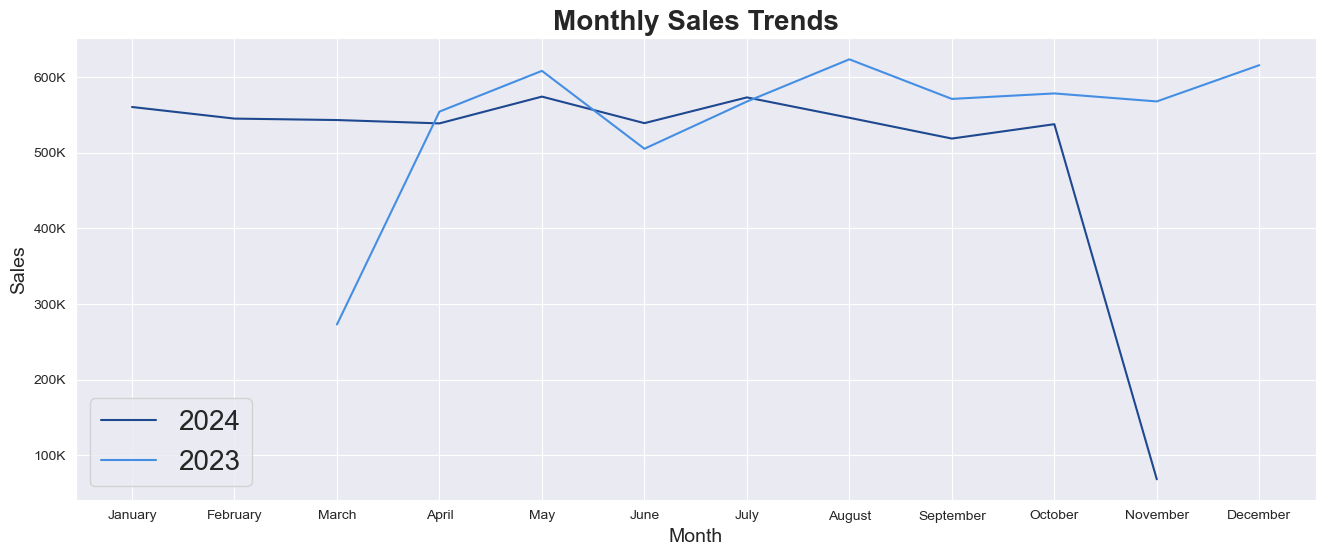

In [20]:
# Line chart comparing monthly sales trends for the year 2023 and 2024
import matplotlib.ticker as mticker

# Set up the plot
plt.figure(figsize=(16,6))
plt.plot(df_24['MonthName'],df_24['Total'],color='#1e488f',label='2024')
plt.plot(df_23['MonthName'],df_23['Total'],color='#448ee4',label='2023')

# Enhance the plot
plt.title("Monthly Sales Trends",fontdict={'fontweight' : 'bold','fontsize' :20 })
plt.legend(fontsize=20)
plt.xlabel("Month",fontsize=14)
plt.ylabel("Sales",fontsize=14)

# Format y axis ticks in thousands 
formatter=mticker.FuncFormatter(lambda x,pos:f'{int(x/1000)}K')
plt.gca().yaxis.set_major_formatter(formatter)

# Display the plot
plt.show()

> The 2023 trend line showed a significant increase in sales after March and remained consistently higher than 2024 trend line for most of the year. However 2024 maintained a relatively stable trend until October, when it experienced a sharp drop, likely due to missing data. This drop explains why, despite higher monthly sales in 2023, the yearly totals in the bar chart were close with 2024 slightly ahead. This suggests that while 2023 had stronger mid-year performance, 2024 showed steady growth before the missing data issue.

### 4) Monthly Trend of Order Count

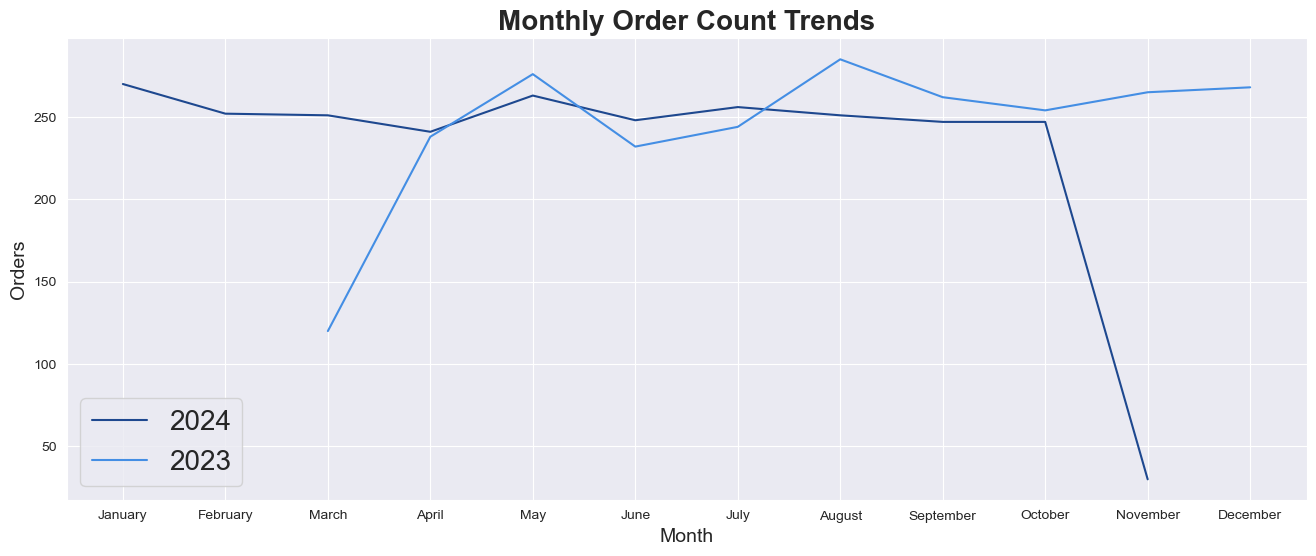

In [21]:
# Line chart comparing monthly order count trends for the year 2023 and 2024

# Set up the plot
plt.figure(figsize=(16,6))
plt.plot(df_24['MonthName'],df_24['Total_Orders'],color='#1e488f',label='2024')
plt.plot(df_23['MonthName'],df_23['Total_Orders'],color='#448ee4',label='2023')

# Enhance the plot
plt.title("Monthly Order Count Trends",fontdict={'fontweight' : 'bold','fontsize' :20 })
plt.legend(fontsize=20)
plt.xlabel("Month",fontsize=14)
plt.ylabel("Orders",fontsize=14)

# Display the plot
plt.show()

> The monthly order count trends follow a similar pattern to the monthly order sales trends, confirming that both order volume and total sales moved in tandem.

### 5) Quarterly Running Total Sales

In [22]:
Sales_Trends = pd.read_sql_query("""select a.Year,a.quarter,sum(a.total_sales)over(order by a.Year,a.quarter) as quarterly_running_total from 
                    (
                    select Year,quarter(order_date) as quarter,sum(order_total) as total_sales
                    from orders group by year,quarter order by Year,quarter
                    )
                     a """,conn)
display(Sales_Trends)

,Year,quarter,quarterly_running_total
0,2023,1,272878.96
1,2023,2,1940664.93
2,2023,3,3702895.00
3,2023,4,5464757.60
4,2024,1,7113453.12
5,2024,2,8765446.33
6,2024,3,10403447.91
7,2024,4,11009308.50


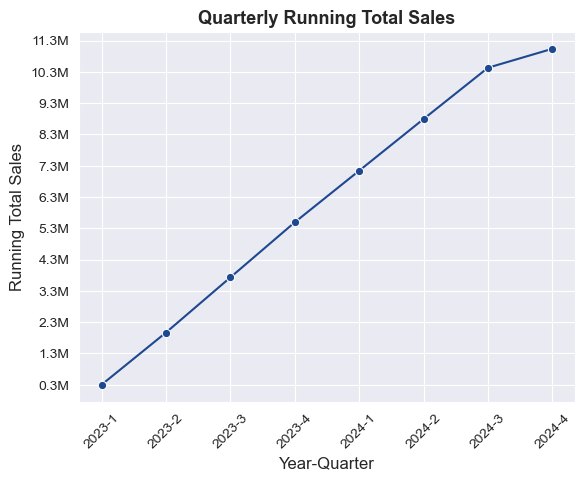

In [23]:
# Line chart showing quarterly running total sales 

# Set up the plot
Sales_Trends['Year_Quarter']=Sales_Trends['Year'].astype(str)+'-'+Sales_Trends['quarter'].astype(str)
sns.lineplot(x=Sales_Trends['Year_Quarter'],y=Sales_Trends['quarterly_running_total'],marker='o',color='#1e488f')

# Enhance the plot
plt.xlabel('Year-Quarter',fontsize=12)
plt.ylabel('Running Total Sales',fontsize=12)
plt.title('Quarterly Running Total Sales',fontdict={'fontweight' : 'bold','fontsize':13})
plt.xticks(rotation=45)
y_min,y_max=Sales_Trends['quarterly_running_total'].min(),Sales_Trends['quarterly_running_total'].max()
plt.yticks(np.arange(y_min,y_max+1e6,1e6),labels=[f"{y/1e6:.1f}M" for y in np.arange(y_min,y_max+1e6,1e6)])

# Display the plot
plt.show()                      

>The quarterly running total sales trend shows consistent growth across all quarters, indicating a steady increase in cumulative sales over time. The trend aligns with the yearly bar chart where 2024 had slightly higher total sales than 2023. This is also reflected in the monthly trends that despite fluctuations which could be due to missing data, the overall upward trajectory confirms that business performance has been improving with 2024 likely surpassing 2023 in full-year sales if all data were available. There are no drops or pleateaus which suggests that sales have been growing each quarter without decline.

### 6) Top 10 Locations by Total Sales

In [24]:
top_10_areas=pd.read_sql_query("""select c.area,sum(c.total_orders) Total_Orders, sum(o.order_total) Sales
                    from customers c 
                    join orders o on c.customer_id=o.customer_id
                    group by c.area 
                    order by Sales desc
                    limit 10""",conn)
top_10_areas

,area,Total_Orders,Sales
0,Orai,495.0,99590.96
1,Deoghar,460.0,95386.05
2,Nandyal,355.0,83281.10
3,Gandhinagar,363.0,82273.95
4,Bhopal,426.0,78854.32
5,Ghaziabad,257.0,72599.85
6,Ahmednagar,300.0,72233.14
7,Jabalpur,344.0,70135.67
8,Jalna,286.0,69086.31
9,Ratlam,352.0,67426.31


### 7) Bottom 10 Locations by Total Sales

In [25]:
bottom_10_areas=pd.read_sql_query("""select c.area,sum(c.total_orders) Total_Orders, sum(o.order_total) Sales
                    from customers c 
                    join orders o on c.customer_id=o.customer_id
                    group by c.area 
                    order by Sales 
                    limit 10""",conn)
bottom_10_areas

,area,Total_Orders,Sales
0,Mangalore,3.0,3211.74
1,Bokaro,20.0,4537.77
2,Dharmavaram,96.0,4807.08
3,Srikakulam,63.0,7314.25
4,Bhalswa Jahangir Pur,53.0,7364.51
5,Raichur,46.0,7818.17
6,Nadiad,82.0,8062.85
7,Vasai-Virar,67.0,9437.64
8,Gopalpur,69.0,9707.97
9,Cuttack,36.0,10532.30


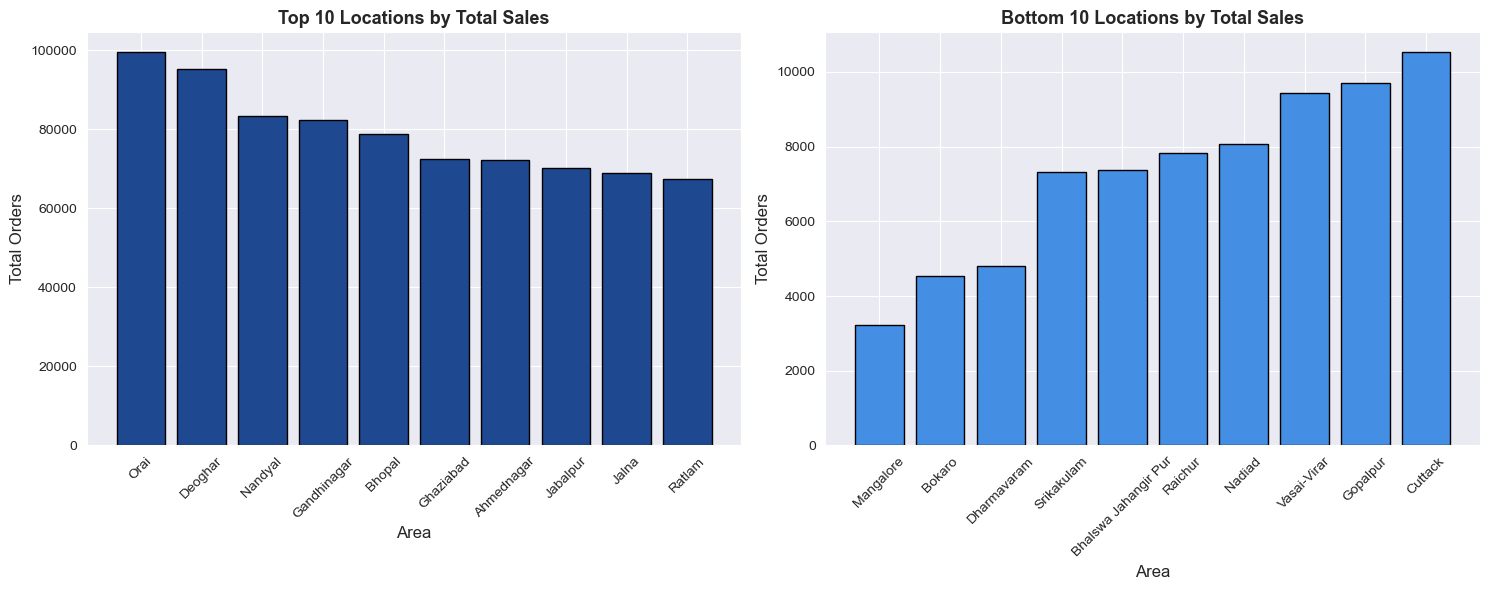

In [26]:
fig,axes = plt.subplots(1,2,figsize=(15,6))

# Plot top 10 Locations
axes[0].bar(top_10_areas['area'],top_10_areas['Sales'],color='#1e488f',edgecolor='k')
axes[0].set_title("Top 10 Locations by Total Sales",fontdict={'fontweight' : 'bold','fontsize':13})
axes[0].set_xlabel("Area",fontsize=12)
axes[0].set_ylabel("Total Orders",fontsize=12)
axes[0].tick_params(axis='x',rotation=45)

# Plot Bottom 10 Locations
axes[1].bar(bottom_10_areas['area'],bottom_10_areas['Sales'],color='#448ee4',edgecolor='k')
axes[1].set_title("Bottom 10 Locations by Total Sales",fontdict={'fontweight' : 'bold','fontsize':13})
axes[1].set_xlabel("Area",fontsize=12)
axes[1].set_ylabel("Total Orders",fontsize=12)
axes[1].tick_params(axis='x',rotation=45)


plt.tight_layout()
plt.show()

## Product Insights

### 1) Top 5 best selling products by quantity

In [27]:
pd.read_sql_query("""select p.product_name,p.category,round(avg(p.price)) as Average_Price,sum(oi.quantity) as Quantity_sold
                    from orders o join order_items oi on o.order_id=oi.order_id
                    join products p on oi.product_id=p.product_id
                    group by p.product_name,p.category
                    order by Quantity_sold desc
                    limit 5""",conn)

,product_name,category,Average_Price,Quantity_sold
0,Pet Treats,Pet Care,536.0,473.0
1,Toilet Cleaner,Household Care,455.0,430.0
2,Dish Soap,Household Care,462.0,397.0
3,Vitamins,Pharmacy,683.0,380.0
4,Cough Syrup,Pharmacy,541.0,373.0


### 2) Number of Products per Category

In [28]:
pd.read_sql_query("""select category, count(distinct product_id) Number_of_Products 
                    from products
                    group by category
                    order by Number_of_Products desc""",conn)

,category,Number_of_Products
0,Dairy & Breakfast,30
1,Fruits & Vegetables,27
2,Household Care,27
3,Snacks & Munchies,27
4,Personal Care,25
5,Pet Care,25
6,Pharmacy,25
7,Grocery & Staples,24
8,Cold Drinks & Juices,22
9,Instant & Frozen Food,20


### 3) Segment products into cost ranges and count how many products fall into each segment

In [29]:
pd.read_sql_query("""
            with product_segments as
           ( select product_id , 
            case 
            when product_costprice < 100 then 'Below 100'
            when product_costprice between 100 and 500 then '100-500'
            when product_costprice between  500 and 1000 then '500-1000'
            else 'Above 1000'
            end as cost_range from order_items ) 
            select count(distinct product_id) as No_of_Products, cost_range 
            from product_segments
            group by cost_range
            order by No_of_Products desc""",conn)

,No_of_Products,cost_range
0,219,500-1000
1,164,Above 1000
2,141,100-500
3,30,Below 100


### 4) Total No. of Products Sold per Category

In [30]:
dd=pd.read_sql_query("""select o.year,p.category,sum(oi.quantity) as Total_Items_Sold
                    from orders o join order_items oi on o.order_id=oi.order_id
                    join products p on oi.product_id=p.product_id
                    group by o.year,p.category
                    order by category
                   """,conn) 
dd

,year,category,Total_Items_Sold
0,2024,Baby Care,332.0
1,2023,Baby Care,323.0
2,2024,Cold Drinks & Juices,380.0
3,2023,Cold Drinks & Juices,378.0
4,2024,Dairy & Breakfast,558.0
5,2023,Dairy & Breakfast,556.0
6,2024,Fruits & Vegetables,454.0
7,2023,Fruits & Vegetables,512.0
8,2024,Grocery & Staples,472.0
9,2023,Grocery & Staples,423.0


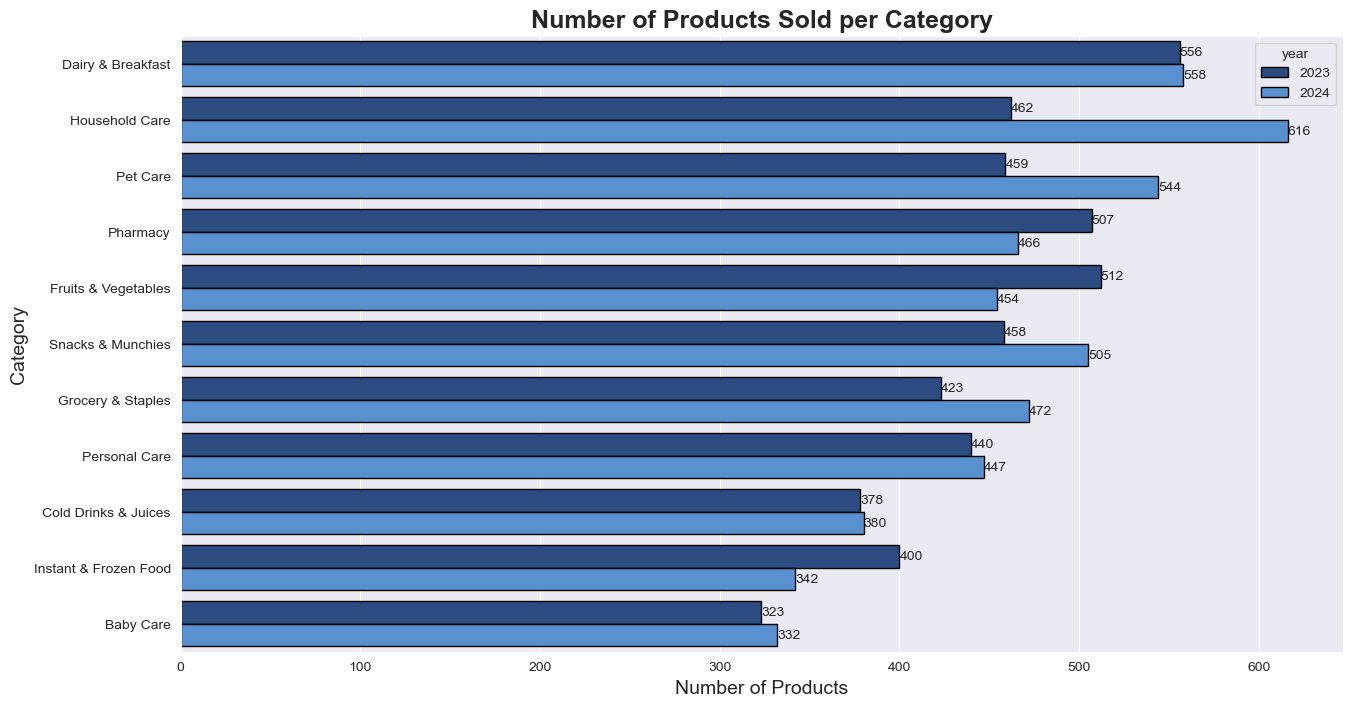

In [31]:
# Grouped bar chart comparing the number of products sold per category for 2023 and 2024 

# Set up the plot
plt.figure(figsize=(15,8))

# Aggregate Total_Items_Sold per category
category_sales=dd.groupby('category')['Total_Items_Sold'].sum().reset_index()
# Sort categories by Total_Items_Sold in descending order
category_sales=category_sales.sort_values(by='Total_Items_Sold',ascending=False)
# Define category order base on sorted Total_Items_Sold
sorted_categories=category_sales['category'].tolist()
# Set category order in the original dataframe
dd['category']=pd.Categorical(dd['category'],categories=sorted_categories,ordered=True)

# Enhance the plot
ax=sns.barplot(x='Total_Items_Sold',y='category',hue='year',data=dd,orient='h',palette=['#1e488f','#448ee4'],edgecolor='k')
plt.title("Number of Products Sold per Category",fontdict={'fontweight' : 'bold','fontsize' :18})
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel("Number of Products",fontsize=14)
plt.ylabel("Category",fontsize=14)

# Display the plot
plt.show()

### 5) Sales per Category

In [32]:
Sales_by_category=pd.read_sql_query("""select p.category,sum(o.order_total) as Total_Sales
                    from orders o join order_items oi on o.order_id=oi.order_id
                    join products p on oi.product_id=p.product_id
                    group by p.category
                    order by Total_Sales desc
                   """,conn) 
Sales_by_category

,category,Total_Sales
0,Dairy & Breakfast,1244368.69
1,Household Care,1136440.47
2,Pet Care,1125103.80
3,Fruits & Vegetables,1085102.76
4,Pharmacy,1055811.97
5,Snacks & Munchies,1043581.94
6,Grocery & Staples,1005494.87
7,Personal Care,1003163.40
8,Cold Drinks & Juices,828002.23
9,Instant & Frozen Food,741183.31


### 6) Yearly comparison of product category performance  

In [33]:
data=pd.read_sql_query("""with yearly_product_sales as
                    ( select o.year,p.category,sum(o.order_total) as current_sales
                    from orders o join order_items oi on o.order_id = oi.order_id
                    join products p on oi.product_id = p.product_id
                    group by o.year, p.category
                    )
                    select year,category,current_sales,
                    lag(current_sales) over(partition by category order by year) as py_sales,
                    current_sales - lag(current_sales) over(partition by category order by year) as diff_py,
                    case
                    when current_sales - lag(current_sales) over(partition by category order by year) >0 then 'Increase'
                    when current_sales - lag(current_sales) over(partition by category order by year) <0 then 'Decrease'
                    else 'No Change' 
                    end as py_change
                    from yearly_product_sales
                    order by category,year""",conn)

data

,year,category,current_sales,py_sales,diff_py,py_change
0,2023,Baby Care,373756.01,NaN,NaN,No Change
1,2024,Baby Care,367299.05,373756.01,-6456.96,Decrease
2,2023,Cold Drinks & Juices,413984.43,NaN,NaN,No Change
3,2024,Cold Drinks & Juices,414017.80,413984.43,33.37,Increase
4,2023,Dairy & Breakfast,681133.71,NaN,NaN,No Change
5,2024,Dairy & Breakfast,563234.98,681133.71,-117898.73,Decrease
6,2023,Fruits & Vegetables,565675.00,NaN,NaN,No Change
7,2024,Fruits & Vegetables,519427.76,565675.00,-46247.24,Decrease
8,2023,Grocery & Staples,502738.44,NaN,NaN,No Change
9,2024,Grocery & Staples,502756.43,502738.44,17.99,Increase


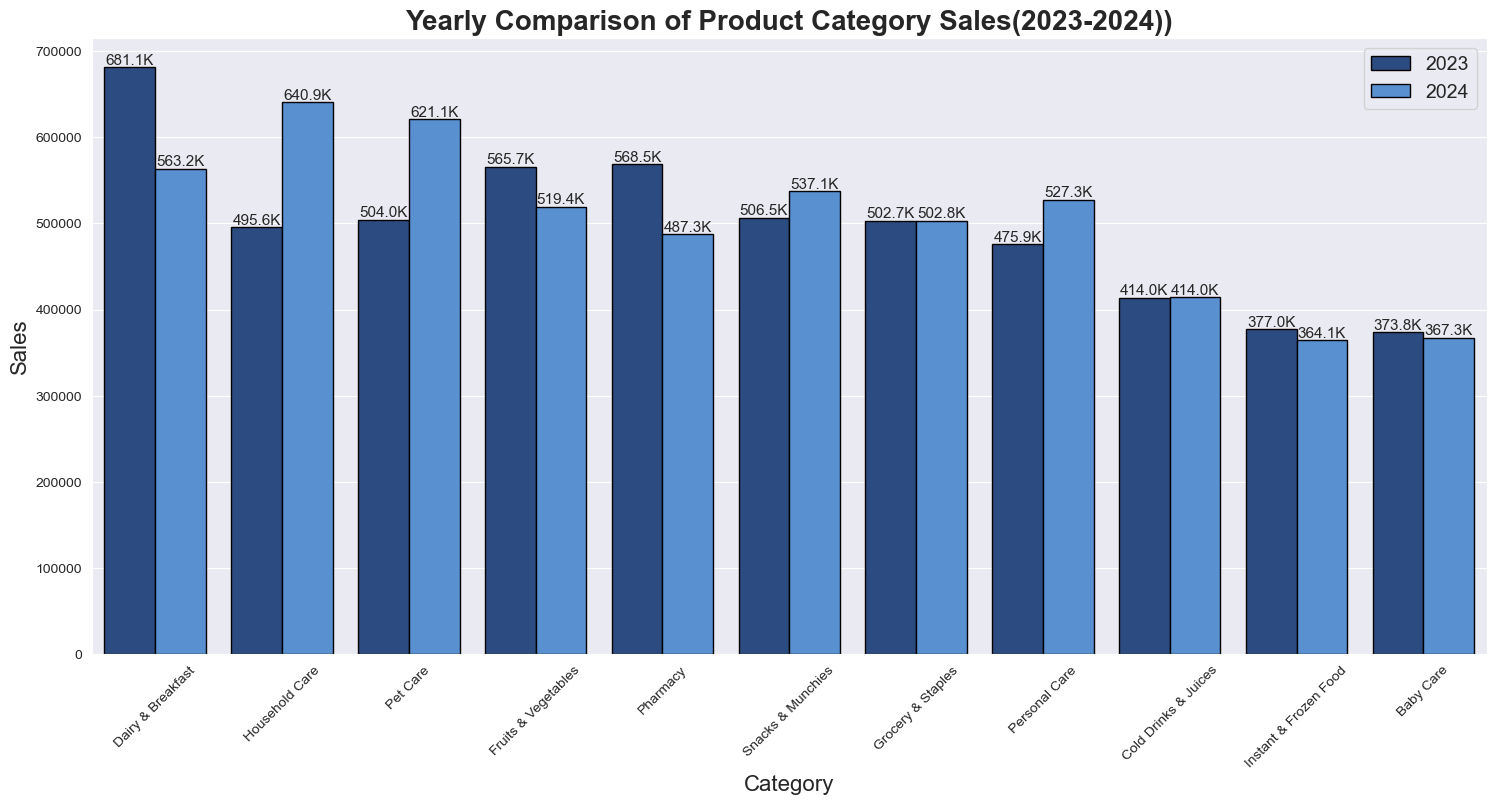

In [34]:
# Countplot showing yearly comparison of product category performance

# Define category order base on sorted Sales by Category
sorted_categories=Sales_by_category['category'].tolist()
# Set category order in the original dataframe
data['category']=pd.Categorical(data['category'],categories=sorted_categories,ordered=True)

# Set up the plot
plt.figure(figsize=(18,8))
ax=sns.barplot(x='category',y='current_sales',hue = 'year',data = data,palette=['#1e488f','#448ee4'],edgecolor='k')

# Enhance the plot
for p in ax.patches:
    height = p.get_height() + 5 
    ax.annotate(f'{p.get_height()/1e3:.1f}K' ,
                (p.get_x()+p.get_width()/2,height),
                ha='center',va='bottom',fontsize=11 )
plt.title("Yearly Comparison of Product Category Sales(2023-2024))",fontdict={'fontweight' : 'bold','fontsize' :20 })
plt.xlabel("Category",fontsize=16)
plt.ylabel("Sales",fontsize=16)
plt.legend(fontsize=14)
plt.xticks(rotation=45)

# Display the plot
plt.show()

> The Product Analysis reveals that the **best-selling products come primarily from the Household Care, Pharmacy and Pet Care categories**. While **Dairy and Breakfast and Household Care have the highest number of products, Baby Care has the least variety and sales**, suggesting lower consumer demand. **Most products fall within the 500-1000 price range**, aligning with the best-selling categories, indicating a **consumer preference for for mid-range pricing**. Yearly sales comparisons show **Dairy & Breakfast, Household Care and Pet Care lead in revenue**, while **Instant & Frozen Food and Baby Care lag behind**. These insights collectively suggest that **consumer spending prioritizes everyday necessities, mid-range pricing attracts higher demand, and product variety does not always translate to increased sales.**

## Delivery Insights

### 1) Delivery Distribution by Time Range

In [35]:
Delivery_TimeRange = pd.read_sql_query("""select dp.*,o.delivery_time_wrt_order_time,
                                        case when o.delivery_time_wrt_order_time <=10 then "Within 10 minutes"
                                             when o.delivery_time_wrt_order_time >10 and o.delivery_time_wrt_order_time <=20 then "10-20 minutes" 
                                             when o.delivery_time_wrt_order_time >20 and o.delivery_time_wrt_order_time <=30 then "20-30 minutes"
                                             when o.delivery_time_wrt_order_time >30 and o.delivery_time_wrt_order_time <=40 then "30-40 minutes"
                                             when o.delivery_time_wrt_order_time >40 and o.delivery_time_wrt_order_time <=50 then "40-50 minutes"
                                             else "more than 50 minutes"                                        
                                        end as TimeRange
                                        from delivery_performance dp join orders o
                                        on dp.order_id=o.order_id""",conn)


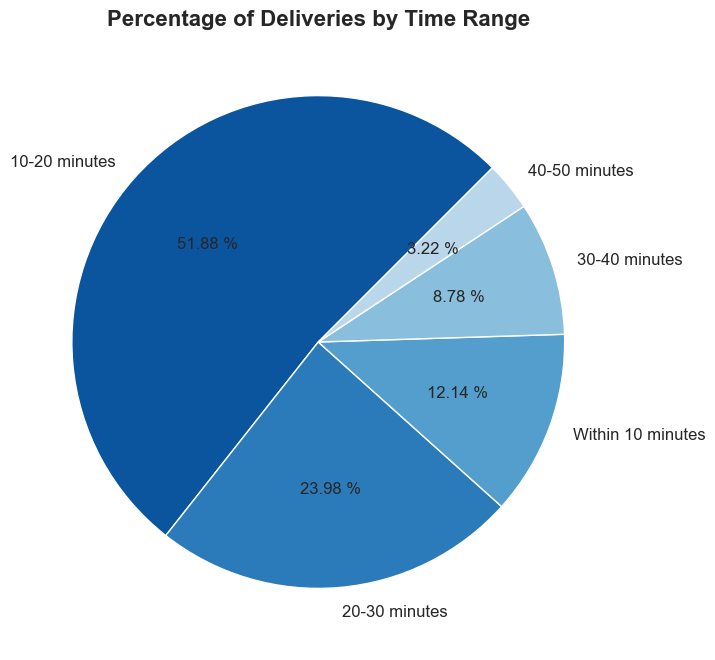

In [36]:
# Pie chart showing percentage of deliveries by different ranges of time

# Set up the plot
Timerange = Delivery_TimeRange['TimeRange'].value_counts(normalize=True)
plt.figure(figsize=(8,8))

# Enhance the plot
plt.title("Percentage of Deliveries by Time Range",fontdict={'fontweight' : 'bold','fontsize' :16 })
palette=sns.color_palette("Blues")
palette.reverse()
plt.pie(Timerange,startangle=45,autopct= '%.2f %%',colors=palette,labels=Timerange.index,textprops={'fontsize':12})

# Display the plot
plt.show()

> The majority of deliveries **(51.88%)** are completed **within 10-20 minutes**, reflecting a fairly efficient system. However only **12.14% are delivered within 10 minutes**, which is relatively low and could be improved to enhance user experience and maintain a strong market position. Additionally 24% of deliveries take 20-30 minutes, while 8.78% take 30-40 minutes and 3.22% extend to 40-50 minutes. While the majority of deliveries are fairly quick, optimizing operations to reduce longer delivery times and increase ultra-fast deliveries can further improve efficiency and customer loyalty. 

### 2) Average Delivery Time by Distance

In [37]:
TimeDist=pd.read_sql_query("""select distance_km,round(avg(delivery_time_minutes)) as Avg_DeliveryTime
                    from delivery_performance 
                    group by distance_km
                    order by distance_km""",conn)

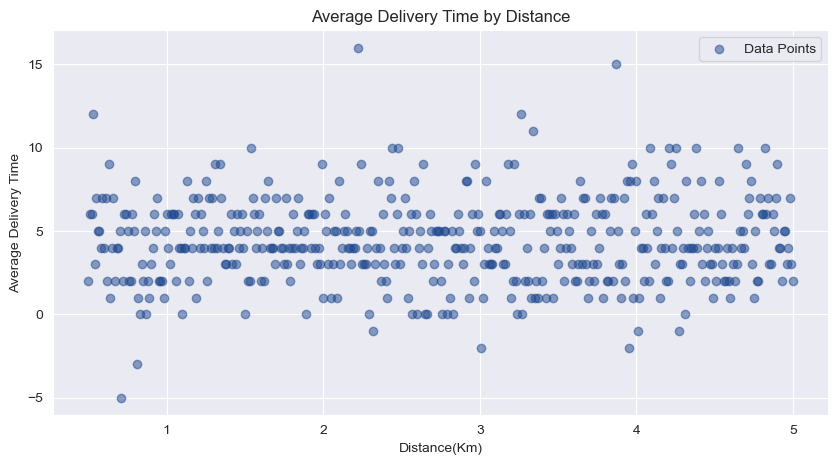

In [38]:
# Scatter plot showing correlation between average delivery time and distance

# Set up the plot
plt.figure(figsize=(10,5))
plt.scatter(TimeDist['distance_km'],TimeDist['Avg_DeliveryTime'],color='#1e488f',alpha=0.5,label='Data Points')

# Enhance the plot
plt.xlabel("Distance(Km)")
plt.ylabel("Average Delivery Time")
plt.title("Average Delivery Time by Distance")
plt.legend()

# Display the plot
plt.show()

> The scatter plot shows no clear relationship between average delivery time and the distance as the points are widely scattered. Most deliveries fall within 3 to 6 minutes, regardless of distance, meaning other factors (eg., traffic, order preparation time) might play a bigger role than just distance.  

### 3) Delivery Status Overview

In [39]:
del_st=pd.read_sql_query("""select delivery_status, count(order_id) Number_of_Orders
                    from delivery_performance
                    group by delivery_status""",conn)

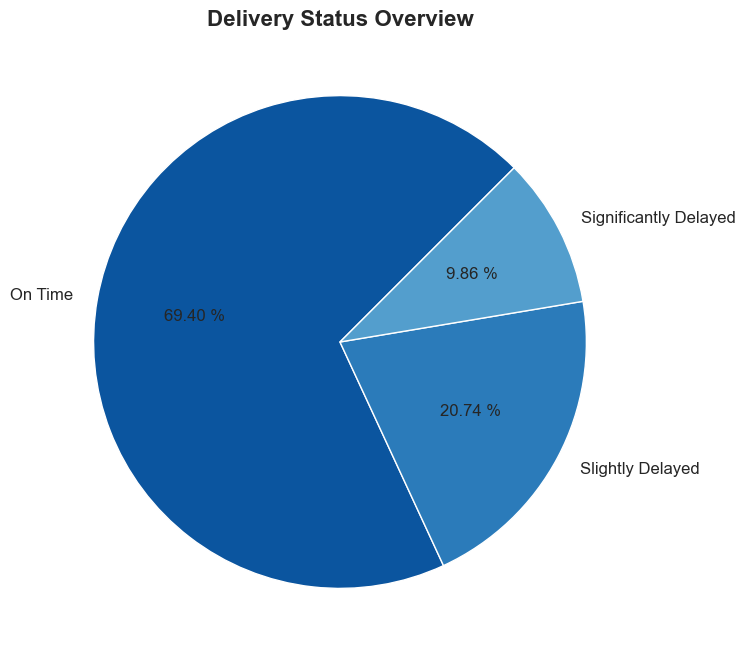

In [40]:
# Pie chart showing percentage of deliveries by delivery status

# Set up the plot
plt.figure(figsize=(8,8))

# Enhance the plot
plt.title("Delivery Status Overview",fontdict={'fontweight' : 'bold','fontsize' :16 })
palette=sns.color_palette("Blues")
palette.reverse()
plt.pie(del_st['Number_of_Orders'],startangle=45,autopct= '%.2f %%',colors=palette,labels=del_st['delivery_status'],textprops={'fontsize':12})

# Display the plot
plt.show()

> Majority of deliveries **(69.40%)** are completed **on time** indicating a reliable delivery process. **Slightly delayed(20.74%)** & **significantly delayed(9.86%)** deliveries make up to almost one-third of total deliveries. Slightly delayed are twice as common as significantly delayed, suggesting minor inefficiencies rather than severe delays.

## Customer Insights

### 1) Top 10 customers who have generated highest revenue

In [41]:
pd.read_sql_query("""select c.customer_name,c.area,c.customer_segment,sum(o.order_total) Total
                    from orders o join customers c on o.customer_id=c.customer_id
                    group by c.customer_name,c.area,c.customer_segment,c.total_orders,c.avg_order_value
                    order by Total desc
                    limit 10""",conn)

,customer_name,area,customer_segment,Total
0,Rayaan Krishna,Muzaffarnagar,New,21686.80
1,Nidhi Sha,Gandhinagar,Premium,19052.94
2,Warda Kohli,Madhyamgram,Regular,19028.36
3,Bakhshi De,Yamunanagar,New,18912.97
4,Atharv Kurian,Jabalpur,Premium,18856.11
5,Jhalak Rai,Dhule,New,18409.90
6,Umang Dhingra,Guna,Inactive,17857.34
7,Vedika Dugal,Ahmednagar,Inactive,17719.29
8,Odika Kannan,Mahbubnagar,Premium,17638.83
9,Daksh Atwal,Davanagere,Premium,17572.43


### 2) Top 10 Most Recent Customers

In [42]:
pd.read_sql_query("""select c.customer_id,c.customer_name,c.area,max(o.order_date) as last_order_date,sum(o.order_total) Total_spent,
                    datediff(max(o.order_date), min(o.order_date)) as lifespan,datediff(now(), max(o.order_date)) as recency
                    from orders o join customers c on o.customer_id=c.customer_id
                    group by c.customer_id,c.customer_name,c.area,c.customer_segment
                    order by recency limit 10
                    """,conn)

,customer_id,customer_name,area,last_order_date,Total_spent,lifespan,recency
0,95768401,Jyoti Pau,Kadapa,2024-11-04 20:29:15,2731.00,278,133
1,51476157,Abdul Bali,Burhanpur,2024-11-04 01:16:31,10251.23,554,133
2,85198177,Charita Comar,Jammu,2024-11-04 13:50:21,11660.19,456,133
3,6982488,Vanya Sachdev,Jalna,2024-11-04 00:15:51,5723.68,103,133
4,43295656,Wyatt Bhasin,Sagar,2024-11-03 16:41:57,8914.42,589,134
5,82770142,Balveer Brar,Karaikudi,2024-11-03 10:59:49,1195.03,0,134
6,64151769,Teerth Mallick,Mysore,2024-11-03 06:05:51,4440.40,366,134
7,80759416,Pavani Prabhakar,Junagadh,2024-11-03 01:29:11,3299.24,0,134
8,71607166,Inaya Sama,Rohtak,2024-11-03 16:39:53,3816.43,288,134
9,90299101,Kamala Kakar,Akola,2024-11-03 03:47:18,2238.94,0,134


### 3) Customer Order Distribution by Segment

In [43]:
c_seg=pd.read_sql_query("""select c.customer_segment,count(distinct c.customer_id) No_of_customers
                    from orders o join customers c on o.customer_id=c.customer_id
                    group by c.customer_segment
                    order by No_of_customers desc
                    """,conn)
c_seg

,customer_segment,No_of_customers
0,Regular,574
1,Premium,550
2,New,530
3,Inactive,518


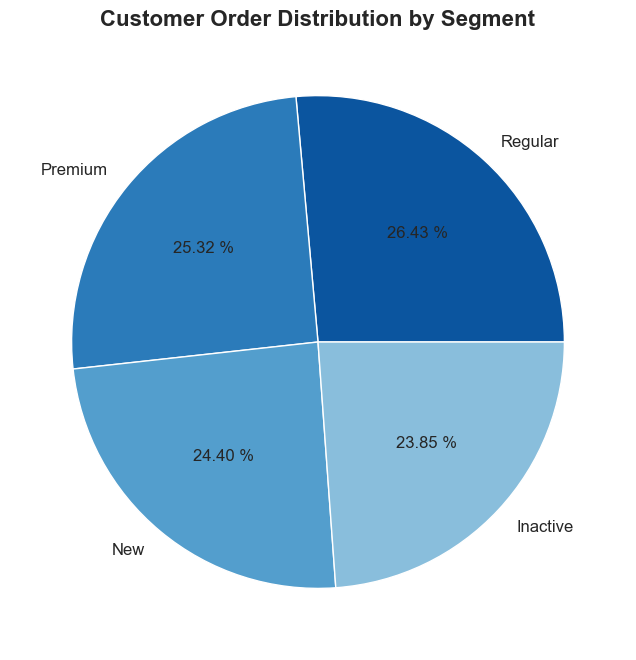

In [44]:
# Pie chart showing customer order distribution by customer segments

# Set up the plot
plt.figure(figsize=(8,8))

# Enhance the plot
plt.title("Customer Order Distribution by Segment",fontdict={'fontweight' : 'bold','fontsize' :16 })
palette=sns.color_palette("Blues")
palette.reverse()
plt.pie(c_seg['No_of_customers'],autopct= '%.2f %%',colors=palette,labels=c_seg['customer_segment'],textprops={'fontsize':12})

# Display the plot
plt.show()

> Customer order distribution is fairly balanced among all segments. Regular and Premium customers make up the largest share of orders. This suggests that loyal, repeat customers contribute significantly to the business. A substantial portion come from new customers indicating strong customer acquisition efforts. Nearly a quarter of the orders were placed by customers who are now inactive. This suggests that many customers engage for a short period before dropping off.

### 4) Percentage of customers who placed an order vs. who did not

In [45]:
c_ord=pd.read_sql_query("""select "Ordered" as If_Ordered,count(distinct c.customer_id) as Customers
                        from customers c join orders o on c.customer_id = o.customer_id 
                        union 
                        select "Total_Orders" as If_Ordered, count(distinct customer_id) as Customers
                        from customers
                        """,conn)
c_ord

,If_Ordered,Customers
0,Ordered,2172
1,Total_Orders,2500


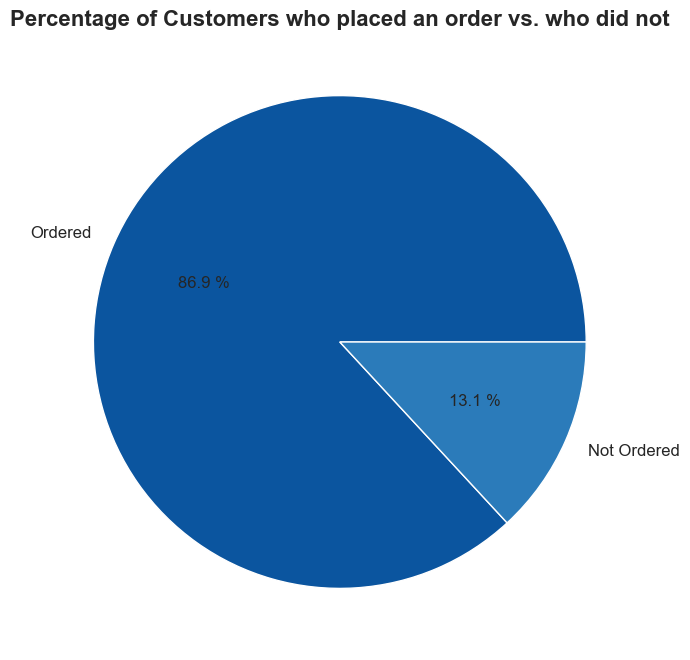

In [46]:
# Pie chart showing percentage of customers who placed an order vs. those who did not

# Set up the plot
plt.figure(figsize=(8,8))
labels=['Ordered','Not Ordered']
sizes=[2172,(2500-2172)]

# Enhance the plot
plt.title("Percentage of Customers who placed an order vs. who did not",fontdict={'fontweight' : 'bold','fontsize' :16 })
palette=sns.color_palette("Blues")
palette.reverse()
plt.pie(sizes,autopct= '%.1f %%',colors=palette,labels=labels,textprops={'fontsize':12})

# Display the plot
plt.show()

> 86.9% of customers have placed atleast one order, while 13.1% have not, indicating strong overall engagement but leaving room for potential reactivation strategies.